In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, svm
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import cv2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import backend as K
import tensorflow as tf

# !pip install SHAP                     # uncomment this line if SHAP was not installed
import shap
# !pip install tensorflow-datasets      # uncomment this line if tensorflow-datasets was not installed
import tensorflow_datasets as tfds

### 23.2.3 Parameter Tuning & Cross Validation

Python has many libraries that provide functions and methods for implementing cross validation in practice.  To give the reader an example, this coding example shows how to optimize a LASSO model using sklearn's `cross_validate()` function, where we try to find the optimal value of the parameter alpha for this model.

In [ ]:
diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]

alpha_list = [0.1, 0.2, 0.5, 1.0]
score_list = []

for alpha in alpha_list:
    model = linear_model.Lasso(alpha=alpha)
    cv_results = cross_validate(model, X, y, cv=5)
    score = cv_results['test_score'].mean()
    score_list.append(score)

opt_idx = np.argmax(score_list)
print('Best model parameter: alpha={}'.format(alpha_list[opt_idx]))

Best model parameter: alpha=0.1


### 23.4.7 Clustering in Practice: Asset Class & Risk-on Risk-off Clusters

In [ ]:
# load data
asset_tickers = ['ACWI', 'AGG', 'EEM', 'EFA', 'EMB', 'GOVT', 'HYG', 'IWM', 'SPY', 'TLT']
df_price = yf.download(asset_tickers, start='2021-01-01', end='2024-02-29', auto_adjust=False)['Adj Close']
df_ret = np.log(df_price/df_price.shift(1)).dropna()
df_ret.tail()

[*********************100%***********************]  10 of 10 completed


Ticker,ACWI,AGG,EEM,EFA,EMB,GOVT,HYG,IWM,SPY,TLT
Date,,,,,,,,,,
2024-02-22,0.017104,0.000825,0.010145,0.011188,0.006294,0.000000,0.004798,0.007550,0.020484,0.004870
2024-02-23,0.000375,0.003705,-0.000492,0.001293,0.005574,0.003544,0.000646,0.002254,0.000689,0.013298
2024-02-26,-0.002720,-0.002160,-0.004443,-0.001422,-0.002840,-0.001328,-0.003237,0.006284,-0.003669,-0.002987
2024-02-27,0.001970,-0.001339,0.001977,0.002713,-0.000910,-0.001773,0.001296,0.014069,0.001856,-0.007077
2024-02-28,-0.004227,0.001957,-0.013173,-0.005823,0.002048,0.002658,-0.000129,-0.008269,-0.001322,0.006329


In [ ]:
# clustering by asset
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(df_ret.T)
pred_labels = kmeans.labels_
df_pred = pd.DataFrame({'ticker': df_ret.columns,
                        'cluster': pred_labels})
df_pred

,ticker,cluster
0,ACWI,1
1,AGG,0
2,EEM,1
3,EFA,1
4,EMB,0
5,GOVT,0
6,HYG,0
7,IWM,1
8,SPY,1
9,TLT,0


In [ ]:
# calculate mean and standard deviation for two clusters
c0 = np.array(asset_tickers)[np.where(pred_labels==0, True, False)].tolist()
c1 = np.array(asset_tickers)[np.where(pred_labels==1, True, False)].tolist()

mean0 = df_ret[c0].values.mean()
mean1 = df_ret[c1].values.mean()

std0 = df_ret[c0].values.std()
std1 = df_ret[c1].values.std()

print(f'Cluster 0 (bonds): mean = {mean0*100:.3f}%, std = {std0*100:.3f}%')
print(f'Cluster 1 (stocks): mean = {mean1*100:.3f}%, std = {std1*100:.3f}%')

Cluster 0 (bonds): mean = -0.020%, std = 0.690%
Cluster 1 (stocks): mean = 0.015%, std = 1.183%


Percentage of risk-on dates: 47.22%
Percentage of risk-off dates: 52.78%


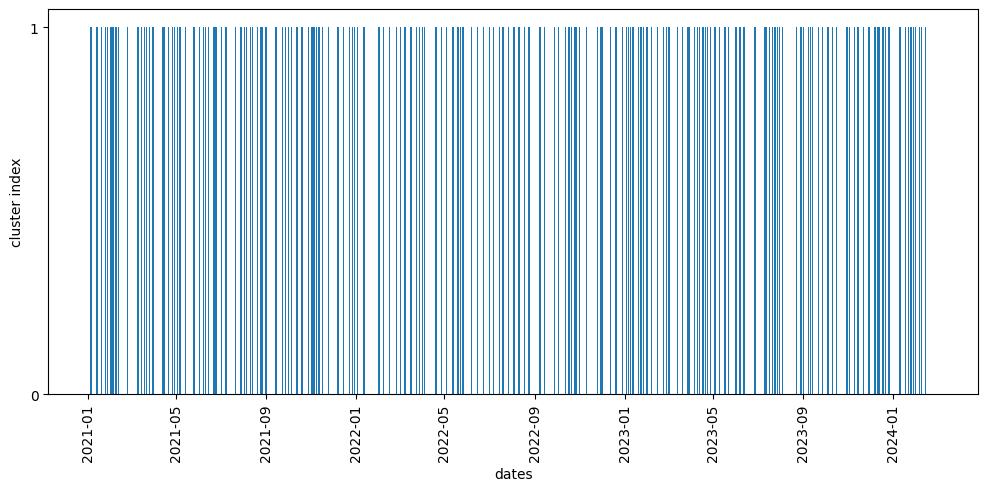

In [ ]:
# clustering by date
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(df_ret)
n_pos = np.where(kmeans.labels_==0, 1, 0).sum()
n_neg = np.where(kmeans.labels_==1, 1, 0).sum()
print('Percentage of risk-on dates: {:.2f}%'.format(n_pos/len(kmeans.labels_)*100))
print('Percentage of risk-off dates: {:.2f}%'.format(n_neg/len(kmeans.labels_)*100))

plt.figure(figsize=(12, 5))
plt.bar(df_ret.index, kmeans.labels_)
plt.yticks([0, 1])
plt.ylabel('cluster index')
plt.xlabel('dates')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# calculate mean and standard deviation for two clusters
c0 = df_ret.index[np.where(kmeans.labels_==1, True, False)]
c1 = df_ret.index[np.where(kmeans.labels_==0, True, False)]

mean0 = df_ret.loc[c0].values.mean()
mean1 = df_ret.loc[c1].values.mean()

std0 = df_ret.loc[c0].values.std()
std1 = df_ret.loc[c1].values.std()

print(f'Cluster 0 (risk-on): mean = {mean0*100:.3f}%, std = {std0*100:.3f}%')
print(f'Cluster 1 (risk-off): mean = {mean1*100:.3f}%, std = {std1*100:.3f}%')

Cluster 0 (risk-on): mean = 0.471%, std = 0.815%
Cluster 1 (risk-off): mean = -0.531%, std = 0.845%


In [ ]:
# calculate mean returns for risk-on and risk-off periods
df_ret_periods = pd.concat([df_pred.set_index('ticker'), df_ret.loc[c0].mean()*100, df_ret.loc[c1].mean()*100], axis=1)
df_ret_periods.index.name = 'ticker'
df_ret_periods.columns = ['cluster', 'risk-on mean return (%)', 'risk-off mean return (%)']
df_ret_periods

,cluster,risk-on mean return (%),risk-off mean return (%)
ticker,,,
ACWI,1,0.741794,-0.770895
AGG,0,0.079030,-0.120162
EEM,1,0.692185,-0.825454
EFA,1,0.705232,-0.751101
EMB,0,0.309842,-0.381054
GOVT,0,0.027856,-0.067516
HYG,0,0.311039,-0.338487
IWM,1,1.035181,-1.134732
SPY,1,0.751864,-0.743729


### 23.5.2 K-Nearest Neighbor

In this coding example, we introduce the implementation of k-nearest neighbor using `sklearn`. The number of neighbors is a hyperparameter that may need tuning to achieve the  optimal model performance, for example via cross validation. Using the `predict()` method, we can use the trained model to predict the class of a new datapoint, with the probability of each class given by `predict_proba()`.

Note that we reuse the ETF and ACWI dataset from 8.2.6.

In [ ]:
# prepare data
df_etf = yf.download(['EPI', 'EWC', 'EWG', 'EWH', 'EWJ', 'EWU', 'EWW', 'EWY', 'EWZ', 'FXI', 'SPY'], start='2016-01-01', end='2024-02-29', auto_adjust=False)['Adj Close']
df_acwi = yf.download('ACWI', start='2016-01-01', end='2024-02-29', auto_adjust=False)[['Adj Close']]
df_ret = np.log(df_etf/df_etf.shift(1)).dropna()
df_acwi_ret = np.log(df_acwi/df_acwi.shift(1)).dropna()
df_acwi_ret['label'] = np.where(df_acwi_ret['Adj Close']>0, 1, 0)

df_data_etf = pd.concat([df_ret.shift(1), df_acwi_ret[['label']]], axis=1).dropna()
df_data_etf.columns = [f'{c}_lag1' for c in df_ret.columns] + ['ACWI']

N = len(df_data_etf)
ntrain = int(N*0.8)

X = df_data_etf.iloc[:,:-1].values
y = df_data_etf.iloc[:,-1].values

X_train = X[:ntrain]
y_train = y[:ntrain]
X_test = X[ntrain:]
y_test = y[ntrain:]

# train the model
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

# predict the first 5 days in the testing period
print('Prediction of ACWI positivity: {}'.format(knn.predict(X_test[:5])))
print('Predicted probabilities of ACWI positivity vs. negativity: {}{}'.format('\n', knn.predict_proba(X_test[:5])))

[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  1 of 1 completed

Prediction of ACWI positivity: [1 0 1 1 1]
Predicted probabilities of ACWI positivity vs. negativity: 
[[0.2 0.8]
 [0.8 0.2]
 [0.4 0.6]
 [0.4 0.6]
 [0.4 0.6]]


### 23.5.5 Support Vector Machines

This coding example shows a general SVM algorithm utilizing `sklearn`. We pass the training data to the initialized model and fit it. We can access the support vectors using the `support_vectors_` attribute. To make predictions for new datapoints, simply pass them to the trained model using the `predict()` method.  Note that the function `svm.SVC()` provides multiple parameters (here we just show the default model) for choosing different regularization levels, kernel functions, etc. These parameters may need to be tuned to achieve optimal model performance. Readers are free to play around with them.

Note that we reuse the dataset from 23.5.2.

In [ ]:
# train the model
model = svm.SVC()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)

# test the model
y_pred_test = model.predict(X_test)

# model performance on train set
print('Traing accuracy: {:.4f}'.format(accuracy_score(y_train, y_pred_train)))
print('======== Confusion Matrix ========')
print(confusion_matrix(y_train, y_pred_train))
print('===== Classification Report ======')
print(classification_report(y_train, y_pred_train, digits=4))

print()

# model performance on test set
print('Test accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred_test)))
print('======== Confusion Matrix ========')
print(confusion_matrix(y_test, y_pred_test))
print('===== Classification Report ======')
print(classification_report(y_test, y_pred_test, digits=4))

Traing accuracy: 0.5945
======== Confusion Matrix ========
[[ 97 637]
 [ 28 878]]
===== Classification Report ======
              precision    recall  f1-score   support

           0     0.7760    0.1322    0.2258       734
           1     0.5795    0.9691    0.7253       906

    accuracy                         0.5945      1640
   macro avg     0.6778    0.5506    0.4756      1640
weighted avg     0.6675    0.5945    0.5018      1640


Test accuracy: 0.5171
======== Confusion Matrix ========
[[ 16 174]
 [ 24 196]]
===== Classification Report ======
              precision    recall  f1-score   support

           0     0.4000    0.0842    0.1391       190
           1     0.5297    0.8909    0.6644       220

    accuracy                         0.5171       410
   macro avg     0.4649    0.4876    0.4018       410
weighted avg     0.4696    0.5171    0.4210       410



### 23.5.8 Classification in Practice: Using Classification Techniques in an Alpha Signal

In [ ]:
# load training data
df_price_train = yf.download('SPY', start='2016-01-01', end='2022-02-28', auto_adjust=False)[['Adj Close']]
df_ret_train = np.log(df_price_train/df_price_train.shift(1)).dropna()
df_ret_train.tail()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close
Ticker,SPY
Date,
2022-02-18,-0.006496
2022-02-22,-0.010790
2022-02-23,-0.017898
2022-02-24,0.014937
2022-02-25,0.021824


In [ ]:
# load testing data
df_price_test = yf.download('SPY', start='2022-03-01', end='2024-02-29', auto_adjust=False)[['Adj Close']]
df_ret_test = np.log(df_price_test/df_price_test.shift(1)).dropna()
df_ret_test.tail()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close
Ticker,SPY
Date,
2024-02-22,0.020484
2024-02-23,0.000689
2024-02-26,-0.003669
2024-02-27,0.001856
2024-02-28,-0.001322


In [ ]:
X_train = df_ret_train.values.reshape(-1, 1)[:-1]
y_train = np.where(df_ret_train>0, 1, 0).reshape(-1)[1:]

X_test = df_ret_test.values.reshape(-1, 1)[:-1]
y_test = np.where(df_ret_test>0, 1, 0).reshape(-1)[1:]

In [ ]:
# svm model
model = svm.SVC(C=1, probability=True)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

prob_pred_train = model.predict_proba(X_train)
prob_pred_test = model.predict_proba(X_test)

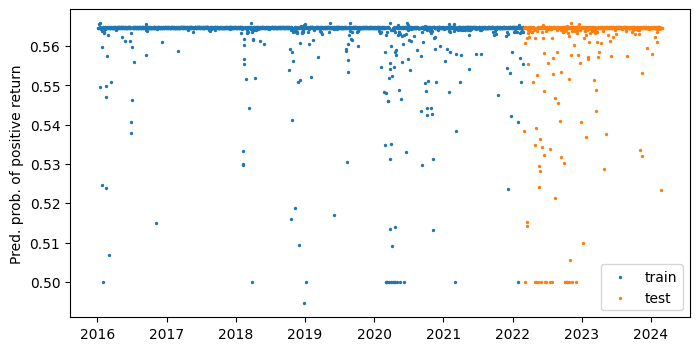

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(df_ret_train.index[1:], prob_pred_train[:,1], s=2, label='train')
plt.scatter(df_ret_test.index[1:], prob_pred_test[:,1], s=2, label='test')
plt.ylabel('Pred. prob. of positive return')
plt.legend()
plt.show()

### 23.6.1 Feature Importance & Interpretability

In this example, we introduce several Python packages that are widely used in the context of feature importance.

The first is `sklearn`, which we have been using throughout this chapter. In addition to providing various types of machine learning models, sklearn allows users to easily access the feature importance scores by calling certain model attributes. For instance, when using logistic regressions, we retrieve the feature importance through the `coef_` attribute. For decisions trees, calling `feature_importances_` provides similar results. Simple visualization provides a straight-forward demonstration.

In [ ]:
# load the iris dataset
data = load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# logistic regression
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
score1 = model.coef_[0]
print(score1)

# decision tree
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
score2 = model.feature_importances_
print(score2)

[-0.39345607  0.96251768 -2.37512436 -0.99874594]
[0.03334028 0.         0.38926487 0.57739485]


We can plot feature importance scores from different models for comparison purposes:

<Axes: xlabel='feature', ylabel='score'>

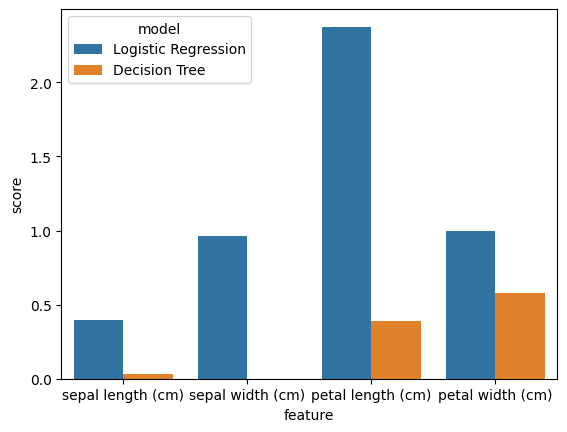

In [ ]:
df_scores = pd.DataFrame({'feature': data.feature_names,
                          'Logistic Regression': abs(score1),
                          'Decision Tree': abs(score2)})
df_scores = df_scores.melt(id_vars='feature', var_name='model', value_name='score')

sns.barplot(data=df_scores, x='feature', y='score', hue='model')

**SHAP** (Shapley Additive Explanations) is a powerful model interpretation tool that usually works with tree ensembles and neural networks. SHAP borrows the idea of Shapley values from game theory and incorporate that into the neural network framework. SHAP works perfectly with common deep learning frameworks such as TensorFlow, Keras, and PyTorch, making feature analysis only one step away from existing models. Take ensemble models for example, SHAP receives a trained model to generate an explainer through the `Explainer()` method. The Shapley values will then be computed by calling the explainer with training data. A sample visualization is provided below. More information about SHAP can be found on the [GitHub repository](https://github.com/slundberg/shap).

In [ ]:
model = XGBRegressor()
model.fit(X_train, y_train)
explainer = shap.Explainer(model)
score = explainer(X_train)
print(score.values.shape)   # n_datapoints x n_features
print(score.values[0])      # check the first datapoint

(120, 4)
[ 0.01771249 -0.01698918 -0.9595782  -0.03283209]


For models dealing with images and therefore have visualization needs, **Grad-CAM** (Gradient-weighted Class Activation Mapping) offers a user-friendly approach that converts feature vectors into visible graphical patterns. It generates a heatmap that measures the importance of all pixels in an image, and we can further combine this heatmap with the original image to understand which part contributes most to the model prediction. A sample heatmap is shown below.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.VP4KLL_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


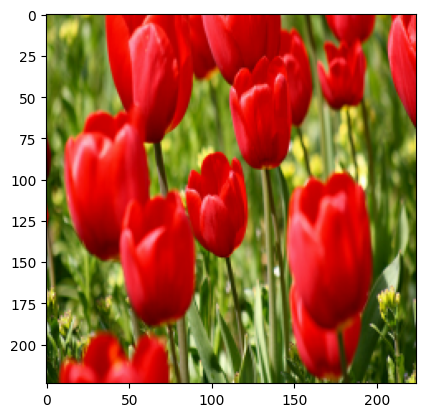

In [ ]:
# load one single image sample from tf_flowers dataset
ds, ds_info = tfds.load('tf_flowers', split='train', with_info=True)
for example in ds.take(1):
    image = example['image'].numpy()
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA).reshape(1, 224, 224, -1)
    plt.imshow(image.squeeze())
    plt.show()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


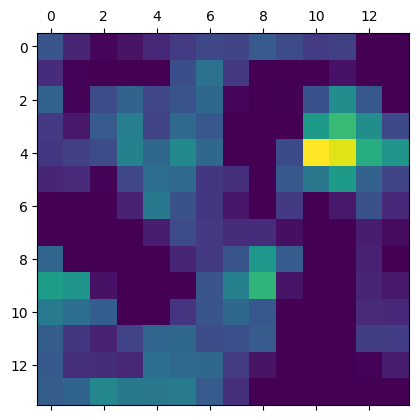

In [ ]:
model = VGG16(weights='imagenet', input_shape=(224, 224, 3))
preds = model.predict(preprocess_input(image))
label_ind = int(tf.argmax(preds[0]))

with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('block5_conv3')
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, label_ind]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

plt.matshow(heatmap.numpy())
plt.show()

As an additional example, below we train a simple MLP on SPY and sector ETF data and plot importance of individual ETFs:

In [ ]:
# load sector ETF data
df_port = yf.download(['XLB', 'XLF', 'XLK', 'XLP', 'XLV'], start='2016-01-01', end='2024-02-29', auto_adjust=False)['Adj Close']
df_port_ret = np.log(df_port/df_port.shift(1)).dropna()
df_port_ret.tail()

[*********************100%***********************]  5 of 5 completed


Ticker,XLB,XLF,XLK,XLP,XLV
Date,,,,,
2024-02-22,0.010013,0.011537,0.032199,0.003090,0.011688
2024-02-23,0.005891,0.004975,-0.002336,0.003080,0.004745
2024-02-26,-0.006007,-0.004975,0.000974,-0.004020,-0.005153
2024-02-27,0.003701,0.002740,0.000875,0.000134,-0.002450
2024-02-28,0.003112,0.003723,-0.004727,0.001073,-0.004987


In [ ]:
# load SPY data
df_spy = yf.download('SPY', start='2016-01-01', end='2024-02-29', auto_adjust=False)[['Adj Close']]
df_spy_ret = np.log(df_spy/df_spy.shift(1)).dropna()
df_spy_ret.tail()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close
Ticker,SPY
Date,
2024-02-22,0.020484
2024-02-23,0.000689
2024-02-26,-0.003669
2024-02-27,0.001856
2024-02-28,-0.001323


In [ ]:
# process data
df_data = pd.concat([df_port_ret.shift(1), df_spy_ret], axis=1).dropna()
df_data.columns = [f'{c}_lag1' for c in df_port_ret.columns] + ['SPY']
df_data.tail()

,XLB_lag1,XLF_lag1,XLK_lag1,XLP_lag1,XLV_lag1,SPY
Date,,,,,,
2024-02-22,0.005515,0.003032,-0.006304,0.003640,0.002202,0.020484
2024-02-23,0.010013,0.011537,0.032199,0.003090,0.011688,0.000689
2024-02-26,0.005891,0.004975,-0.002336,0.003080,0.004745,-0.003669
2024-02-27,-0.006007,-0.004975,0.000974,-0.004020,-0.005153,0.001856
2024-02-28,0.003701,0.002740,0.000875,0.000134,-0.002450,-0.001323


In [ ]:
N = len(df_data)
ntrain = int(N*0.8)

X = df_data.iloc[:,:-1].values
y = df_data.iloc[:,-1].values

X_train = X[:ntrain]
y_train = y[:ntrain]
X_test = X[ntrain:]
y_test = y[ntrain:]

In [ ]:
# 3-layer MLP
reg = MLPRegressor(hidden_layer_sizes=(5,5,5),
                   activation='relu',
                   random_state=1)
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train[:,::-1])
y_pred_test = reg.predict(X_test)

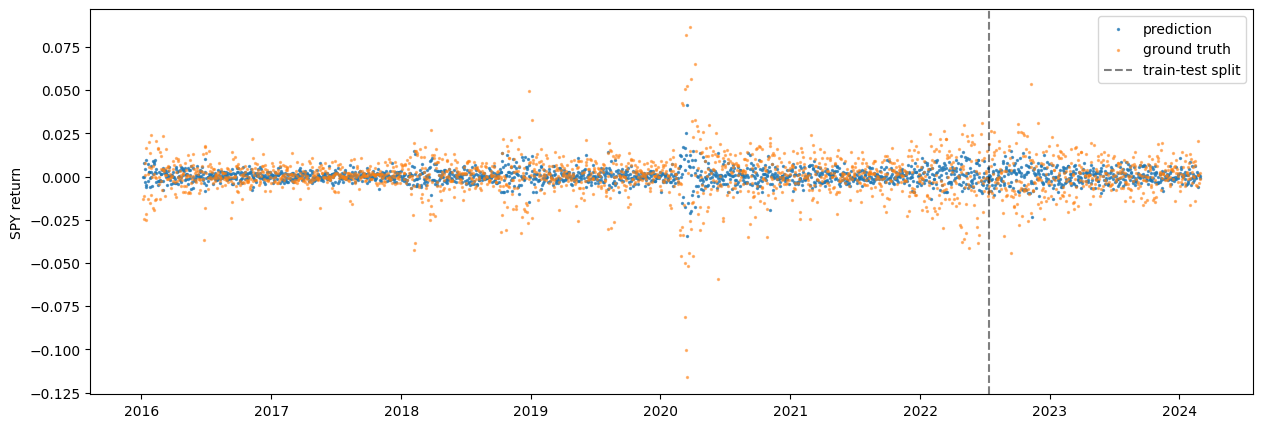

In [ ]:
# plot model predictions
plt.figure(figsize=(15,5))
plt.scatter(df_data.index, np.concatenate([y_pred_train, y_pred_test]), s=2, alpha=.7, label='prediction')
plt.scatter(df_data.index, y, s=2, alpha=.5, label='ground truth')
plt.axvline(x=df_data.index[ntrain], color='black', alpha=.5, ls='--', label='train-test split')
plt.ylabel('SPY return')
plt.legend()
plt.show()

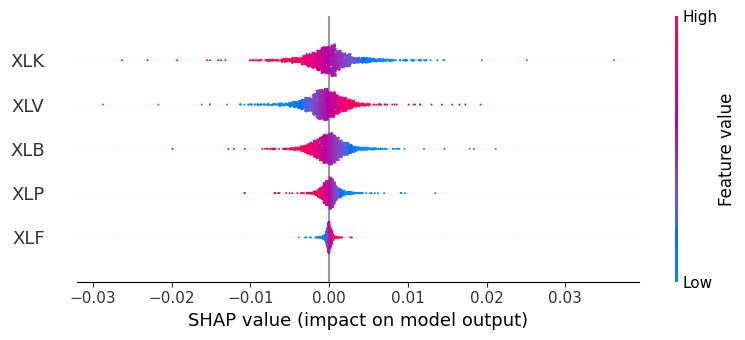

In [ ]:
explainer_reg = shap.Explainer(reg.predict, X_train, feature_names=['XLB', 'XLF', 'XLK', 'XLP', 'XLV'])
shap_values_reg = explainer_reg(X_train)

shap.plots.beeswarm(shap_values_reg, s=2, show=False)
plt.tight_layout()
plt.show()

We will see that SHAP scores, which capture and reflect the model's non-linearity,  don't necessarily coincide with correlations, which are linear. Also, as SHAP accounts for interactions and dependencies among features, for features with multi-colinearility, SHAP values can also be different from correlations.


In [ ]:
df_data.corr()[['SPY']]

,SPY
XLB_lag1,-0.104402
XLF_lag1,-0.153506
XLK_lag1,-0.129797
XLP_lag1,-0.141698
XLV_lag1,-0.155017
SPY,1.000000
